In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum, asc

spark = SparkSession.builder \
    .appName("FM Analyze Parquet - Structured") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

# Load origination and servicing data
orig_df1 = spark.read.parquet("/content/drive/MyDrive/freddie_data/2022Q4_orig.parquet").persist()
svcg_df1 = spark.read.parquet("/content/drive/MyDrive/freddie_data/2022Q4_svcg.parquet").persist()

orig_df2 = spark.read.parquet("/content/drive/MyDrive/freddie_data/2023Q1_orig.parquet").persist()
svcg_df2 = spark.read.parquet("/content/drive/MyDrive/freddie_data/2023Q1_svcg.parquet").persist()


In [ ]:
print("Origination Schema 2022Q4:")
orig_df1.printSchema()

print("Servicing Schema 2022Q4:")
svcg_df1.printSchema()

print("Origination Schema 2023Q1:")
orig_df2.printSchema()

print("Servicing Schema 2023Q1:")
svcg_df2.printSchema()

Origination Schema 2022Q4:
root
 |-- credit_score: integer (nullable = true)
 |-- first_payment_date: integer (nullable = true)
 |-- first_homebuyer_flag: string (nullable = true)
 |-- maturity_date: integer (nullable = true)
 |-- msa: integer (nullable = true)
 |-- mi_percentage: integer (nullable = true)
 |-- num_units: integer (nullable = true)
 |-- occupancy_status: string (nullable = true)
 |-- orig_cltv: integer (nullable = true)
 |-- orig_dti: integer (nullable = true)
 |-- orig_upb: integer (nullable = true)
 |-- orig_ltv: integer (nullable = true)
 |-- orig_interest_rate: double (nullable = true)
 |-- channel: string (nullable = true)
 |-- ppm_flag: string (nullable = true)
 |-- amortization_type: string (nullable = true)
 |-- property_state: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- postal_code: integer (nullable = true)
 |-- loan_seq_num: string (nullable = true)
 |-- loan_purpose: string (nullable = true)
 |-- orig_loan_term: integer (nullab

In [ ]:
print("2022Q4 Origination Sample:")
orig_df1.select("loan_seq_num", "credit_score", "orig_cltv", "orig_dti").show(5)

print("2022Q4 Servicing Sample:")
svcg_df1.select("loan_seq_num", "mthly_reporting_period", "current_loan_delinq_status").show(5)


2022Q4 Origination Sample:
+------------+------------+---------+--------+
|loan_seq_num|credit_score|orig_cltv|orig_dti|
+------------+------------+---------+--------+
|F22Q30333929|         721|       97|      37|
|F22Q40000001|         716|       68|      40|
|F22Q40000002|         789|       95|      28|
|F22Q40000003|         763|       67|      39|
|F22Q40000004|         792|       76|      37|
+------------+------------+---------+--------+
only showing top 5 rows

2022Q4 Servicing Sample:
+------------+----------------------+--------------------------+
|loan_seq_num|mthly_reporting_period|current_loan_delinq_status|
+------------+----------------------+--------------------------+
|F22Q40129688|                202305|                         0|
|F22Q40129688|                202306|                         0|
|F22Q40129688|                202307|                         0|
|F22Q40129688|                202308|                         0|
|F22Q40129688|                202309|        

In [ ]:
def add_dq_flags(df):
    df = df.withColumn("delinquency_status", col("current_loan_delinq_status").cast("int"))
    df = df.withColumn("temp_dq", when(col("delinquency_status") >= 3, 1).otherwise(0))
    df = df.withColumn("long_dq", when((col("loan_age") - (col("ddlpi") % 100)) >= 6, 1).otherwise(0))
    df = df.withColumn("final_dq", when(
        col("zero_balance_code").isin(3, 9, 15, 16, 96) | (col("actual_loss_calc") > 0), 1
    ).otherwise(0))
    return df

svcg_df1 = add_dq_flags(svcg_df1)
svcg_df2 = add_dq_flags(svcg_df2)


In [ ]:
print("2022Q4 Delinquents:")
svcg_df1.select("loan_seq_num", "mthly_reporting_period", "temp_dq", "long_dq", "final_dq")\
    .filter("final_dq = 1").orderBy("loan_seq_num").show(5)

print("2023Q1 Delinquents:")
svcg_df2.select("loan_seq_num", "mthly_reporting_period", "temp_dq", "long_dq", "final_dq")\
    .filter("final_dq = 1").orderBy("loan_seq_num").show(5)


2022Q4 Delinquents:
+------------+----------------------+-------+-------+--------+
|loan_seq_num|mthly_reporting_period|temp_dq|long_dq|final_dq|
+------------+----------------------+-------+-------+--------+
|F22Q40000031|                202302|      0|      0|       1|
|F22Q40000117|                202302|      0|      0|       1|
|F22Q40000152|                202303|      0|      0|       1|
|F22Q40000209|                202212|      0|      0|       1|
|F22Q40000412|                202302|      0|      0|       1|
+------------+----------------------+-------+-------+--------+
only showing top 5 rows

2023Q1 Delinquents:
+------------+----------------------+-------+-------+--------+
|loan_seq_num|mthly_reporting_period|temp_dq|long_dq|final_dq|
+------------+----------------------+-------+-------+--------+
|F23Q10000061|                202305|      0|      0|       1|
|F23Q10000192|                202304|      0|      0|       1|
|F23Q10000287|                202306|      0|      0|

In [ ]:
def summarize_dq(df):
    return df.groupBy("loan_seq_num").agg(
        sum("temp_dq").alias("total_temp_dq"),
        sum("long_dq").alias("total_long_dq"),
        sum("final_dq").alias("total_final_dq")
    )

label_df1 = summarize_dq(svcg_df1)
label_df2 = summarize_dq(svcg_df2)
combined_label = label_df1.unionByName(label_df2)


In [ ]:
combined_orig = orig_df1.unionByName(orig_df2)

df_joined = combined_orig.join(combined_label, on="loan_seq_num", how="inner")
df_joined.printSchema()

df_joined.select("loan_seq_num", "credit_score", "total_temp_dq", "total_final_dq").show(5)


root
 |-- loan_seq_num: string (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- first_payment_date: integer (nullable = true)
 |-- first_homebuyer_flag: string (nullable = true)
 |-- maturity_date: integer (nullable = true)
 |-- msa: integer (nullable = true)
 |-- mi_percentage: integer (nullable = true)
 |-- num_units: integer (nullable = true)
 |-- occupancy_status: string (nullable = true)
 |-- orig_cltv: integer (nullable = true)
 |-- orig_dti: integer (nullable = true)
 |-- orig_upb: integer (nullable = true)
 |-- orig_ltv: integer (nullable = true)
 |-- orig_interest_rate: double (nullable = true)
 |-- channel: string (nullable = true)
 |-- ppm_flag: string (nullable = true)
 |-- amortization_type: string (nullable = true)
 |-- property_state: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- postal_code: integer (nullable = true)
 |-- loan_purpose: string (nullable = true)
 |-- orig_loan_term: integer (nullable = true)
 |-- num_borrowe

In [ ]:
df_joined.write.mode("overwrite").option("compression", "gzip").parquet("/content/drive/MyDrive/freddie_data/2022Q4_2023Q1_ML.parquet")

# U.S. State Analysis With Failed Banks

In [ ]:
# Load Spark session and mortgage ML dataset
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count

spark = SparkSession.builder \
    .appName("Freddie-FDIC State Merge") \
    .getOrCreate()

# Load mortgage data
df = spark.read.parquet("/content/drive/MyDrive/freddie_data/2022Q4_2023Q1_ML.parquet")

# Aggregate mortgage delinquency by state
state_dq = df.groupBy("property_state").agg(
    sum("total_temp_dq").alias("total_temp_dq"),
    sum("total_long_dq").alias("total_long_dq"),
    sum("total_final_dq").alias("total_final_dq"),
    count("*").alias("num_loans")
).withColumn("final_dq_rate", col("total_final_dq") / col("num_loans"))

# Convert to pandas
dq_pd = state_dq.toPandas()
dq_pd.rename(columns = {"property_state": "State"}, inplace = True)


In [ ]:
# Load and clean FDIC failed banks CSV
import pandas as pd

fdic = pd.read_csv("FDIC Failed Bank List.csv", encoding = "latin1")
fdic.columns = fdic.columns.str.strip()
fdic["Closing Date"] = pd.to_datetime(fdic["Closing Date"])
fdic["State"] = fdic["State"].str.upper()

# Aggregate bank failures per state
fdic_state = fdic.groupby("State").size().reset_index(name = "num_failed_banks")


<ipython-input-23-07e32bc81550>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fdic["Closing Date"] = pd.to_datetime(fdic["Closing Date"])


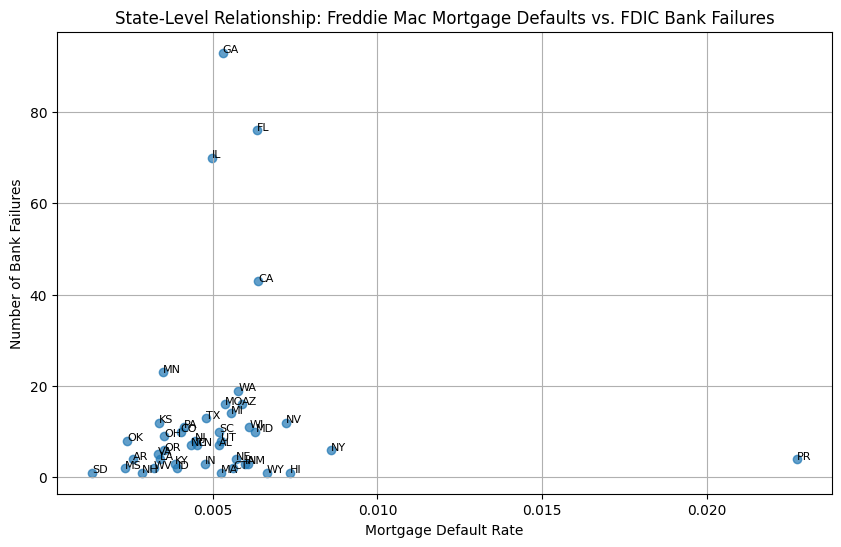

In [ ]:
# Merge both datasets on state
merged = pd.merge(dq_pd, fdic_state, on = "State", how=  "inner")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.scatter(merged["final_dq_rate"], merged["num_failed_banks"], alpha = 0.7)
plt.xlabel("Mortgage Default Rate")
plt.ylabel("Number of Bank Failures")
plt.title("State-Level Relationship: Freddie Mac Mortgage Defaults vs. FDIC Bank Failures")
plt.grid(True)

# Optional: Add state labels
for i, row in merged.iterrows():
    plt.text(row["final_dq_rate"], row["num_failed_banks"], row["State"], fontsize = 8)

plt.show()

In [ ]:
from scipy.stats import pearsonr

r, p = pearsonr(merged["final_dq_rate"], merged["num_failed_banks"])
print(f"Correlation: r = {r:.3f}, p-value = {p:.4f}")

Correlation: r = 0.038, p-value = 0.8055


In [ ]:
pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.1
astropy-iers-data                     0.2025.4.28.0.37.27
astunparse                            1.6.3
atpublic                              5